Install packages

In [ ]:
!pip install pycaret

In [ ]:
!pip install catboost

In [ ]:
!pip install xgboost --upgrade

In [ ]:
!pip install pycaret-ts-alpha

In [ ]:
!pip install streamlit

In [355]:
from pandas.tseries.offsets import *

restart the runtime to ensure newly installed packages are integrated in the runtime

In [1]:
from pycaret.time_series import TSForecastingExperiment

In [91]:
from pycaret.time_series.forecasting.functional import tune_model

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

#from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

In [3]:
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [4]:
import pandas as pd
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

define function for processing the input data

In [5]:
def process_input_data():
    
    # load the data
    input_data = pd.read_excel('spx_features_input_data.xlsx',skiprows=1)
    # drop excess columns
    input_data2 = input_data.drop(columns=['Unnamed: 0','Unnamed: 1'])
    # rename the columns
    input_data2.columns = ['date','sp500','eqsct','hlbeta','eqad','credit','hlindex']
    # set date as index
    input_data3 = input_data2.set_index('date')
    # drop additional row
    input_data4 = input_data3[1:]
    # sort date index
    input_data5 = input_data4.sort_index()
    # set data frequency
    input_data6 = input_data5.asfreq('B') # for business days to avoid weekends
    # impute data
    input_data6.fillna(method='ffill',inplace=True)
    
    return input_data6

In [240]:
def calc_drift_volatility(df = pd.DataFrame()):

  # calc one day delta
  df2 = df.assign(sp500_delta_1_day = df['sp500'].diff(1))
  # calc 5 day drift - mean 1day delta of last 5 days
  df3 = df2.assign(drift_5_day = (df2['sp500_delta_1_day'].rolling(window=5).mean()))
  # calc 10 day drift - mean 1day delta of last 10 days
  df4 = df3.assign(drift_10_day = (df3['sp500_delta_1_day'].rolling(window=10).mean()))
  # get z score of drift
  df4 = df4.assign(z_drift_10_day = (df4['drift_10_day'] - df4['drift_10_day'].rolling(window=10).mean())/df4['drift_10_day'].rolling(window=10).std())
  # get forward 10 day drift
  df4 = df4.assign(z_fwd_drift_10_day = (df4['sp500'].diff(10).shift(-10) - df4['sp500'].diff(10).rolling(window=10).mean())/df4['sp500'].diff(10).rolling(window=10).std())

  # calc 5 day volatility - vol of 1day delta of last 5 days
  df5 = df4.assign(volatility_5_day = df4['sp500_delta_1_day'].rolling(window=5).std())
  # calc 10 day volatility - vol of 1day delta of last 10 days
  df6 = df5.assign(volatility_10_day = df5['sp500'].rolling(window=10).std())
  # get z score of volatility
  df6 = df6.assign(z_volatility_10_day = (df6['volatility_10_day'] - df6['volatility_10_day'].rolling(window=10).mean())/df6['volatility_10_day'].rolling(window=10).std())
  # get forward 10 day vol
  df6 = df6.assign(fwd_volatility_10_day = df6['sp500'].rolling(window=10).std().shift(-10))

  return df6

In [241]:
def prepare_df_for_exp(df = pd.DataFrame(), tgt_n_feature_list=[]):

  df = df[tgt_n_feature_list]

  return df

In [280]:
def process_post_model_features():

  input_data = process_input_data()
  df = input_data
  df2 = df.assign(hist_mu_drift_10_day = df['sp500'].diff(10).rolling(window=10).mean())
  df3 = df2.assign(hist_std_drift_10_day = df2['sp500'].diff(10).rolling(window=10).std())
  df4 = df3.assign(volatility_10_day = df3['sp500'].rolling(window=10).std())
  df5 = df4.assign(z_volatility_10_day = (df4['volatility_10_day'] - df4['volatility_10_day'].rolling(window=10).mean())/df4['volatility_10_day'].rolling(window=10).std())
  df6 = df5.assign(z_fwd_drift_10_day = (df5['sp500'].diff(10).shift(-10) - df5['sp500'].diff(10).rolling(window=10).mean())/df5['sp500'].diff(10).rolling(window=10).std())

  return df6

In [281]:
post_proc_df = process_post_model_features()

In [242]:
def control_function_for_prep():

  # input data
  input_data = process_input_data()
  # calc drift and vol
  drift_vol_df = calc_drift_volatility(df = input_data)
  # define target and feature
  tgt_n_feature_list = ['z_fwd_drift_10_day','z_volatility_10_day','eqsct',
                      'hlbeta','eqad','credit','hlindex']
  # prepare the dataframe
  prep_df = prepare_df_for_exp(df = drift_vol_df, tgt_n_feature_list = tgt_n_feature_list)

  return prep_df

In [243]:
prep_df = control_function_for_prep()

**Univariate Time Series Forecasting with Exogenous Variables**

Exploratory Data Analysis

In [221]:
def eda_experiment(df = pd.DataFrame(), target=''):

  # Create an EDA experiment ----
  eda = TSForecastingExperiment()
  eda.setup(
    data=df,
    target=target,
    fh=10,
    seasonal_period=5,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    # Set defaults for the plots ----
    fig_kwargs={"renderer": "notebook", "width": None, "height": 600},
    session_id=42,
  )

  return eda

In [222]:
eda = eda_experiment(df = prep_df[-260:-10], target='z_fwd_drift_10_day')

,Description,Value
0,session_id,42
1,Target,z_fwd_drift_10_day
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(250, 7)"
5,Train data shape,"(240, 7)"
6,Test data shape,"(10, 7)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


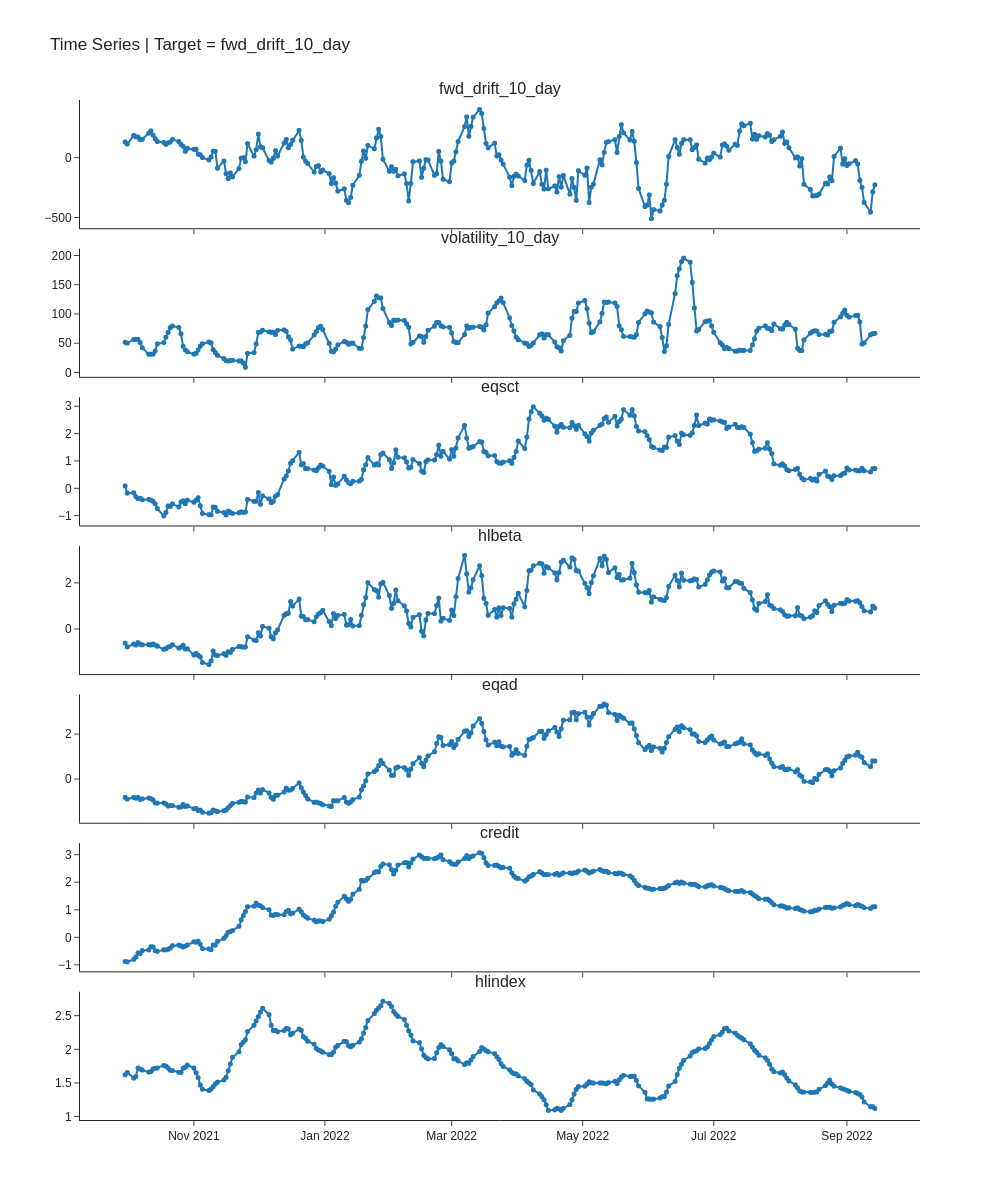

In [160]:
eda.plot_model(
    plot="ts",
    fig_kwargs = {"height":1200,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10,
                  "renderer": "png"}
)

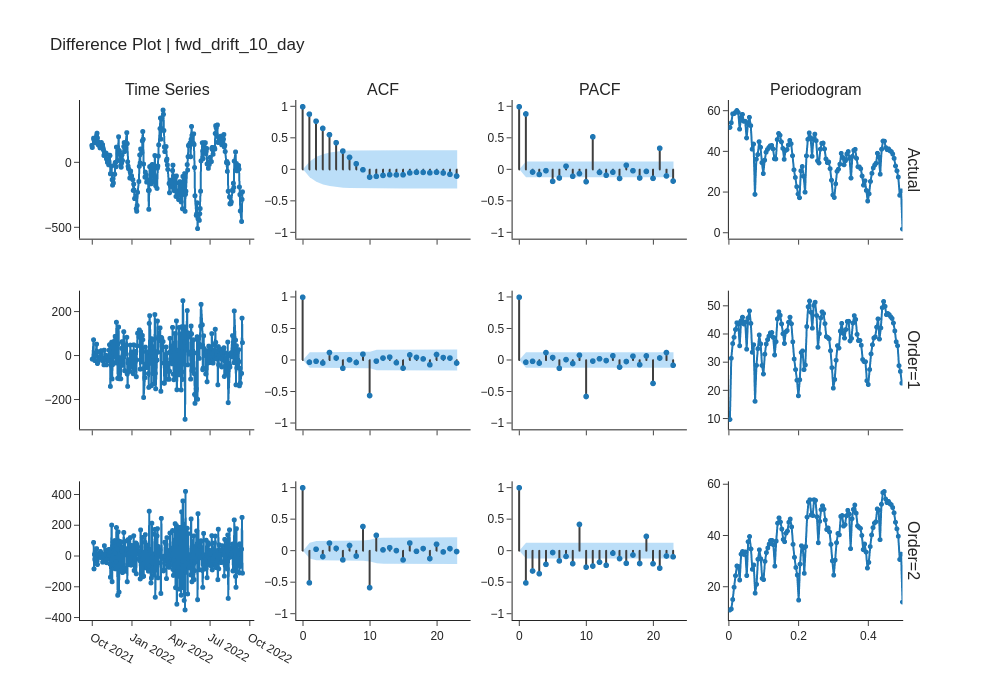

In [161]:
# Plots original data with first difference (order d = 1) by default
eda.plot_model(
    plot="diff",
    fig_kwargs = {"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10,
                  "renderer": "png"},
    data_kwargs={"acf": True, "pacf": True, "periodogram": True, "order_list": [1, 2]}
)

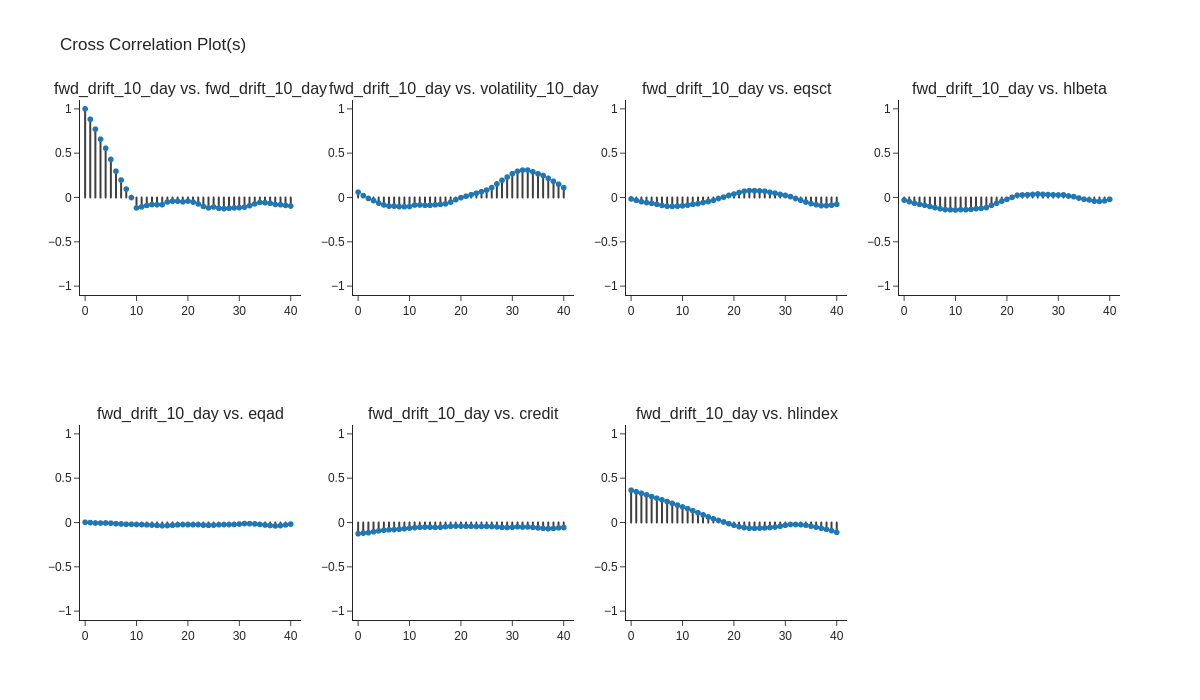

In [162]:
# Plots original data with first difference (order d = 1) by default
eda.plot_model(
    plot="ccf",
    fig_kwargs = {"height":700,"width":1200,"template": "simple_white","hoverinfo":"none","big_data_threshold":10,
                  "renderer": "png"},
)

**Base Model - Univariate drift forecasting without exogenous variable**

In [163]:
def set_baseline_exp(df = pd.DataFrame(), tgt_variable = ''):

  data_uni = df.copy()
  #data_uni.set_index("index", inplace=True)
  data_uni = data_uni[tgt_variable]

  exp_uni = TSForecastingExperiment()
  exp_uni.setup(
      data=data_uni, fh=10,
      seasonal_period=10,
      numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
      fig_kwargs={"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10,
                  "renderer": "png"}, session_id=42
  )

  return exp_uni

In [164]:
exp_uni = set_baseline_exp(df = prep_df[-260:-10], tgt_variable = 'fwd_drift_10_day')

,Description,Value
0,session_id,42
1,Target,fwd_drift_10_day
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(250, 1)"
5,Train data shape,"(240, 1)"
6,Test data shape,"(10, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


In [165]:
model = exp_uni.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,10))

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,102.3004,131.0758,0.6767,0.4397,1.4914,1.5024,-20.4518
1,2022-08-03,199.9437,247.4487,8.1977,1.6584,2.9811,2.8871,-1.3895
2,2022-08-17,411.6539,502.8545,18.5622,1.1127,6.1648,5.8731,-13.9834
Mean,NaT,237.9660,293.7930,9.1455,1.0702,3.5458,3.4209,-11.9416
SD,NaT,129.1231,155.2754,7.3324,0.4984,1.9492,1.8238,7.9149


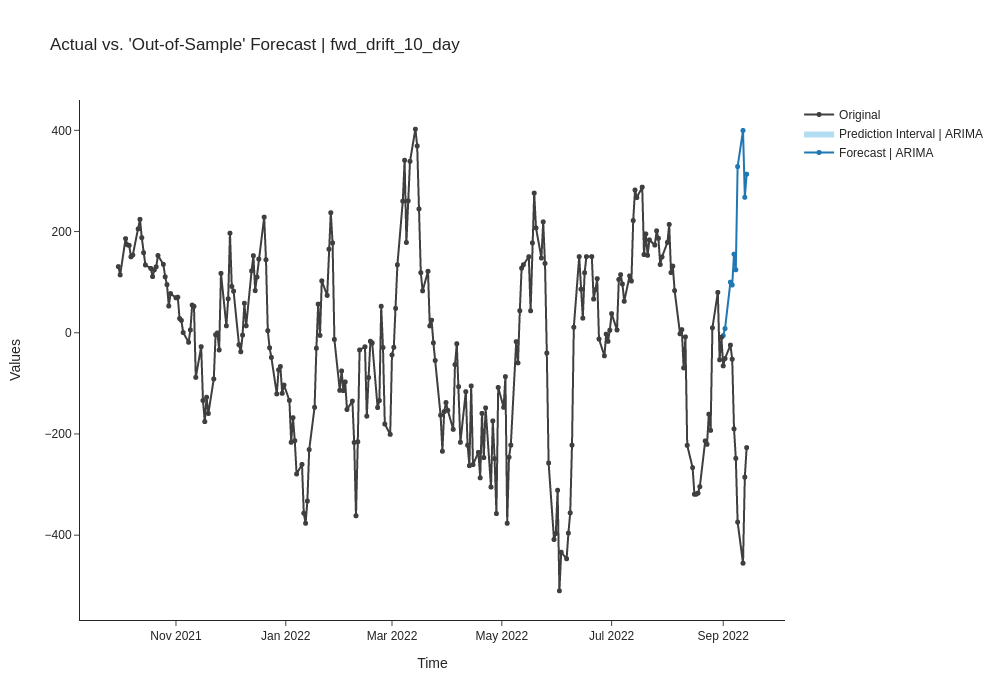

In [166]:
exp_uni.plot_model(model)


In [261]:
def set_univariate_exogenous_exp(df = pd.DataFrame(), tgt_variable=''):

  exp_exo = TSForecastingExperiment()
  exp_exo.setup(
      data=df, target=tgt_variable, fh=10,
      seasonal_period=5,
      fold=3,
      numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
      fig_kwargs={"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10,
                  "renderer": "png"}, session_id=42
  )

  return exp_exo

In [262]:
exp_exo = set_univariate_exogenous_exp(df = prep_df[-260:-10], tgt_variable = 'z_fwd_drift_10_day')

,Description,Value
0,session_id,42
1,Target,z_fwd_drift_10_day
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(250, 7)"
5,Train data shape,"(240, 7)"
6,Test data shape,"(10, 7)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


In [245]:
model_exo = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,5))

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,3.0982,3.4387,9.4395,1.1966,1.3615,1.1952,-7.4849
1,2022-08-03,6.9329,9.5492,0.7774,1.2305,3.0776,3.3617,-0.7892
2,2022-08-17,24.1043,26.9064,507.6376,1.4445,9.7807,8.0449,-27.2846
Mean,NaT,11.3785,13.2981,172.6182,1.2905,4.7399,4.2006,-11.8529
SD,NaT,9.1337,9.9406,236.9209,0.1097,3.6326,2.8586,11.2490


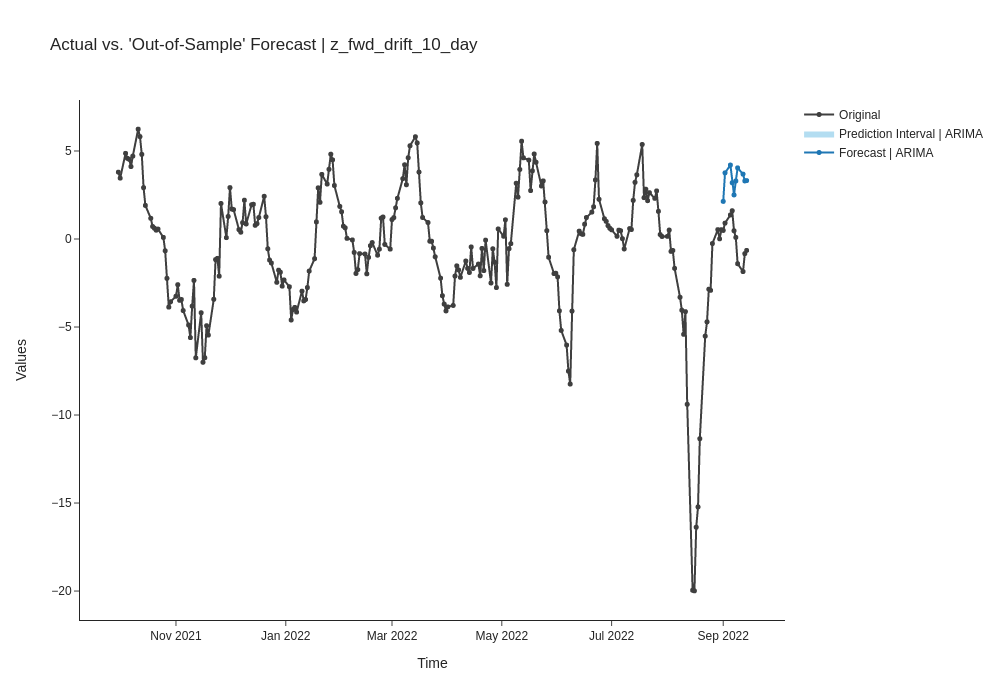

In [246]:
exp_exo.plot_model(model_exo)

**Train Test Split**

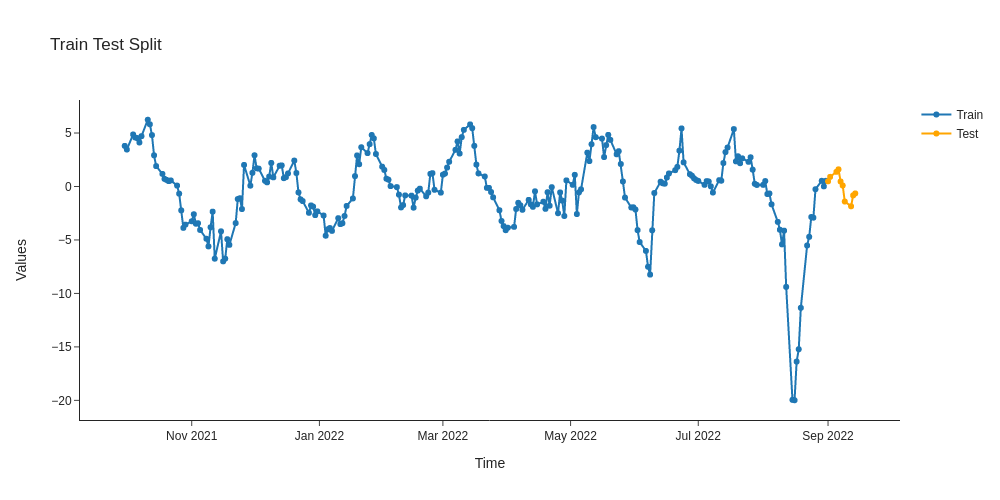

In [247]:
exp_exo.plot_model(plot="train_test_split",fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

**Cross Validation**

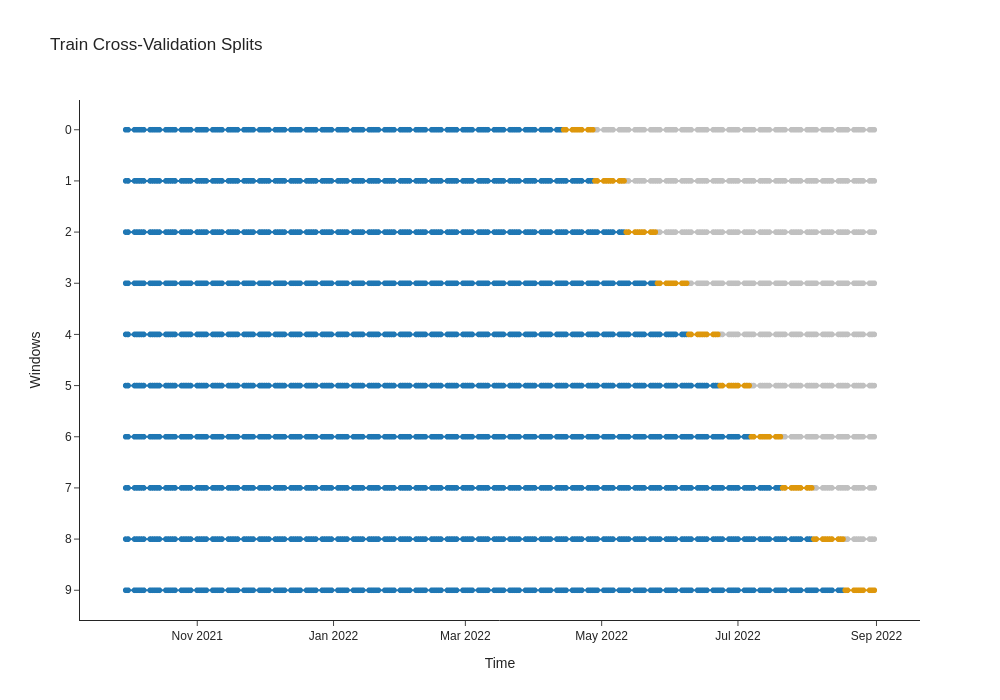

In [259]:
exp_exo.plot_model(plot="cv",fig_kwargs = {"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

**Identifying Best Performing Models**

In [248]:
comp_models = exp_exo.compare_models(n_select=4)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize...,3.6862,4.648,29.3171,0.8682,1.5789,1.5495,0.0793,0.4133
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,3.3134,4.4551,12.6766,0.8772,1.4338,1.5096,0.1601,0.7867
par_cds_dt,Passive Aggressive w/ Cond. Deseasonalize & De...,3.651,4.7545,14.0176,0.8789,1.5595,1.5835,0.0605,0.0967
auto_arima,Auto ARIMA,5.3009,6.464,43.4113,0.9524,2.2325,2.096,-0.9045,11.7367
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,6.1166,7.5507,74.6407,0.9801,2.5695,2.4341,-1.8395,0.9733
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonali...,6.2642,7.3762,73.0132,1.0046,2.6243,2.3656,-1.7973,0.7633
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & De...,4.8068,6.1415,36.6763,1.0066,2.0529,2.0384,-1.8942,9.4933
arima,ARIMA,7.7962,9.3237,109.0854,1.0642,3.2523,2.9628,-3.9858,0.5533
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,3.5595,4.6253,14.7764,1.1105,1.5463,1.5766,-0.0452,0.1300
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,6.7278,8.1235,75.3074,1.132,2.8344,2.6271,-2.1947,1.1467


In [249]:
comp_models

[BaseCdsDtForecaster(regressor=LGBMRegressor(random_state=42), sp=5,
                     window_length=5),
 BaseCdsDtForecaster(regressor=KNeighborsRegressor(n_jobs=-1), sp=5,
                     window_length=5),
 BaseCdsDtForecaster(regressor=PassiveAggressiveRegressor(random_state=42), sp=5,
                     window_length=5),
 AutoARIMA(random_state=42, sp=5, suppress_warnings=True)]

In [255]:
auto_arima = exp_exo.create_model('auto_arima')

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,0.4315,0.5654,1.6152,0.7353,0.1896,0.1965,0.7706
1,2022-08-03,6.0306,8.7168,0.5518,0.8173,2.6771,3.0687,-0.4909
2,2022-08-17,9.4405,10.1098,128.0669,1.3046,3.8306,3.0228,-2.9932
Mean,NaT,5.3009,6.4640,43.4113,0.9524,2.2325,2.0960,-0.9045
SD,NaT,3.7139,4.2095,59.8621,0.2513,1.5193,1.3432,1.5641


In [256]:
pa_reg = exp_exo.create_model("par_cds_dt")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,0.6865,0.7679,1.9410,0.7631,0.3017,0.2669,0.5768
1,2022-08-03,5.5342,8.4553,0.5792,0.6880,2.4567,2.9766,-0.4028
2,2022-08-17,4.7323,5.0403,39.5325,1.1855,1.9202,1.5070,0.0074
Mean,NaT,3.6510,4.7545,14.0176,0.8789,1.5595,1.5835,0.0605
SD,NaT,2.1216,3.1449,18.0503,0.2190,0.9160,1.1075,0.4017


In [174]:
cat_boost = exp_exo.create_model("catboost_cds_dt")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,96.1592,106.3246,0.5610,0.8419,0.6719,0.5647,-13.1151
1,2022-08-03,158.3040,204.4557,5.8249,1.5954,1.1399,1.1086,-0.6313
2,2022-08-17,105.6389,144.2913,5.4222,0.7842,0.7477,0.7760,-0.2337
Mean,NaT,120.0340,151.6905,3.9361,1.0738,0.8532,0.8164,-4.6600
SD,NaT,27.3363,40.4021,2.3922,0.3696,0.2051,0.2239,5.9809


In [175]:
xgboost = exp_exo.create_model("xgboost_cds_dt")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,62.2871,81.8531,0.3335,0.4715,0.4352,0.4347,-7.3654
1,2022-08-03,146.6632,188.9256,3.5165,1.6901,1.0561,1.0244,-0.3929
2,2022-08-17,244.4948,281.2531,10.0474,1.0317,1.7305,1.5126,-3.6873
Mean,NaT,151.1484,184.0106,4.6325,1.0644,1.0739,0.9906,-3.8152
SD,NaT,74.4535,81.4789,4.0435,0.4980,0.5289,0.4407,2.8480


In [176]:
arima = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,10))

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,61.2505,69.4767,0.3901,0.3091,0.4280,0.3690,-5.0269
1,2022-08-03,175.3882,245.3123,4.1169,1.5990,1.2629,1.3301,-1.3484
2,2022-08-17,141.7648,187.2026,6.8578,0.8452,1.0034,1.0068,-1.0766
Mean,NaT,126.1345,167.3305,3.7882,0.9178,0.8981,0.9020,-2.4840
SD,NaT,47.8893,73.1469,2.6506,0.5291,0.3489,0.3993,1.8016


In [177]:
random_forest = exp_exo.create_model("rf_cds_dt")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,100.4576,108.2592,0.5791,0.8523,0.7020,0.5750,-13.6335
1,2022-08-03,186.5421,238.3545,6.1963,1.6237,1.3433,1.2924,-1.2171
2,2022-08-17,190.5543,240.0782,8.7381,0.9261,1.3487,1.2911,-2.4153
Mean,NaT,159.1847,195.5639,5.1712,1.1340,1.1313,1.0528,-5.7553
SD,NaT,41.5586,61.7378,3.4089,0.3476,0.3036,0.3379,5.5921


In [250]:
lightgbm = exp_exo.create_model("lightgbm_cds_dt")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,0.6845,0.8408,0.7589,0.6742,0.3008,0.2922,0.4927
1,2022-08-03,5.9359,8.2650,0.6105,0.8694,2.6351,2.9096,-0.3403
2,2022-08-17,4.4381,4.8382,86.5821,1.0611,1.8008,1.4466,0.0854
Mean,NaT,3.6862,4.6480,29.3171,0.8682,1.5789,1.5495,0.0793
SD,NaT,2.2088,3.0339,40.4925,0.1580,0.9658,1.0710,0.3401


In [251]:
knn = exp_exo.create_model("knn_cds_dt")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,0.5906,0.7263,0.8204,0.5925,0.2595,0.2525,0.6214
1,2022-08-03,6.5032,9.3780,0.6303,0.9774,2.8869,3.3014,-0.7256
2,2022-08-17,2.8464,3.2610,36.5790,1.0617,1.1550,0.9750,0.5845
Mean,NaT,3.3134,4.4551,12.6766,0.8772,1.4338,1.5096,0.1601
SD,NaT,2.4363,3.6316,16.9018,0.2042,1.0906,1.3009,0.6265


**Tune 4 Models - Catboost, XGboost, ARIMA, Random Forest**

In [93]:
tuned_catboost = exp_exo.tune_model(cat_boost)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,29.1477,39.2327,0.2031,0.1708,0.2037,0.2084,-0.9218
1,2022-08-03,56.1358,65.8326,2.2156,0.8776,0.4042,0.3570,0.8309
2,2022-08-17,796.1214,943.2758,34.7608,1.3159,5.6349,5.0728,-51.7233
Mean,NaT,293.8016,349.4470,12.3932,0.7881,2.0809,1.8794,-17.2714
SD,NaT,355.3645,420.0407,15.8376,0.4718,2.5144,2.2589,24.3717


**Blend 4 Models**

In [263]:
blender = exp_exo.blend_models([knn,lightgbm,auto_arima,pa_reg])

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2022-07-20,0.3573,0.4525,0.6045,0.5315,0.1570,0.1573,0.8531
1,2022-08-03,5.9169,8.6768,0.5614,0.7896,2.6266,3.0546,-0.4772
2,2022-08-17,4.2731,4.6904,72.5224,1.0921,1.7339,1.4024,0.1405
Mean,NaT,3.5158,4.6066,24.5627,0.8044,1.5058,1.5381,0.1721
SD,NaT,2.3320,3.3581,33.9126,0.2291,1.0210,1.1867,0.5436


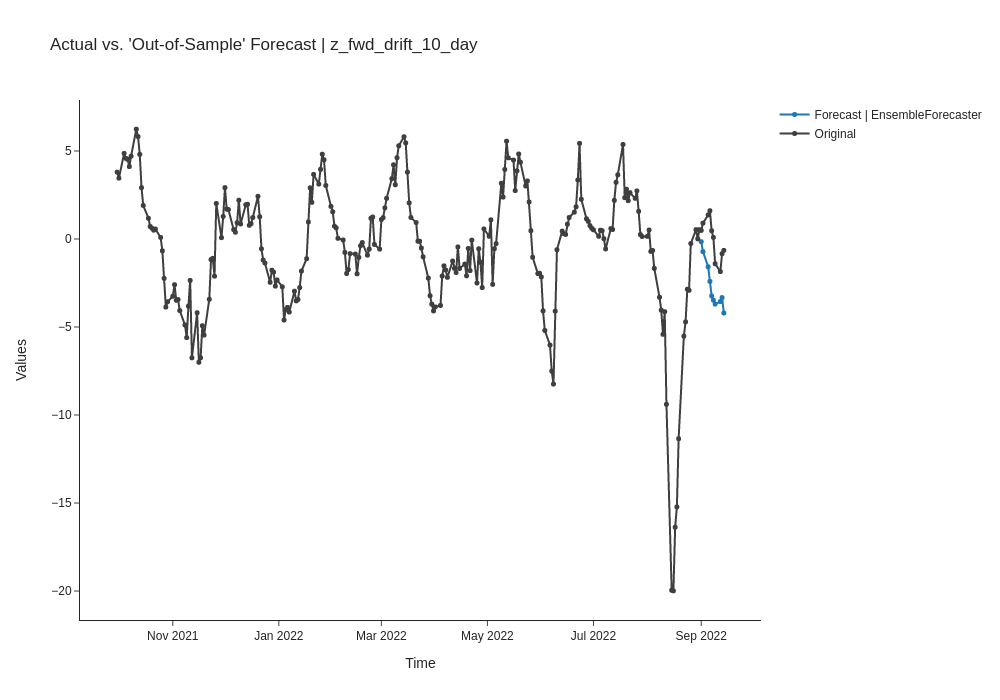

In [264]:
exp_exo.plot_model(blender)

**Finalize the blended model and Predict**

In [265]:
exog_vars = ['eqsct', 'hlbeta', 'eqad',
       'credit', 'hlindex','z_volatility_10_day']

In [266]:
X = prep_df[exog_vars][-10:]

In [267]:
final_model = exp_exo.finalize_model(blender)

In [211]:
arima_final_model = exp_exo.finalize_model(arima)

In [252]:
final_model_exo = exp_exo.finalize_model(knn)

In [ ]:
exp_exo.save_model(final_model, "final_drift_model")

<AxesSubplot:>

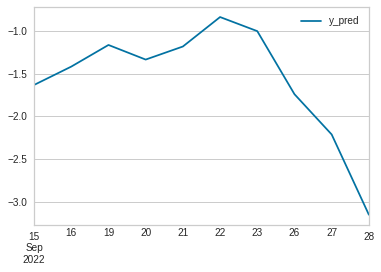

In [345]:
future_preds = exp_exo.predict_model(final_model, X=X)
future_preds.plot()

In [346]:
future_preds

,y_pred
2022-09-15,-1.6326
2022-09-16,-1.4175
2022-09-19,-1.1640
2022-09-20,-1.3352
2022-09-21,-1.1821
2022-09-22,-0.8367
2022-09-23,-1.0018
2022-09-26,-1.7411
2022-09-27,-2.2131
2022-09-28,-3.1537


In [397]:
def process_prediction(future_preds = pd.DataFrame(), post_proc_df = pd.DataFrame()):

    # format data
    future_preds = future_preds.reset_index()
    future_preds['index'] = pd.to_datetime(future_preds['index'].dt.to_timestamp('s'))

    post_proc_df = post_proc_df.reset_index()
    post_proc_df2 = post_proc_df.assign(date_format= pd.to_datetime(pd.DatetimeIndex(post_proc_df['date']).date))

    comb_future_df = pd.merge(post_proc_df2, future_preds, left_on='date_format', right_on='index', how='left')
    raw_shift_val = comb_future_df['y_pred'].iloc[-10] - comb_future_df['z_fwd_drift_10_day'].iloc[-11]
    comb_future_df['y_pred'] = comb_future_df['y_pred'] - raw_shift_val

    comb_future_df2 = comb_future_df.assign(interim_pred = (comb_future_df['y_pred'] *\
                                            comb_future_df['hist_std_drift_10_day']) + comb_future_df['hist_mu_drift_10_day'] + comb_future_df['sp500'])
    
    #comb_future_df3 = comb_future_df2.set_index('date')

    next_date_list = []
    for i in range(1,11):

      obday = comb_future_df['date_format'].iloc[-1] + BusinessDay(i)
      next_date_list.append(obday)

    date_df = pd.DataFrame({'date':next_date_list, 'sp500_pred':list(comb_future_df2['interim_pred'][-10:])})
    # adjust for shift in values
    shift_val = date_df['sp500_pred'].iloc[0] - comb_future_df2['sp500'].iloc[-1]
    date_df['sp500_pred'] = date_df['sp500_pred'] - shift_val

    comb_future_df3 = pd.merge(comb_future_df2, date_df, on='date', how='outer')
    comb_future_df4 = comb_future_df3.set_index('date')


    
    return comb_future_df4

In [398]:
comb_future_df = process_prediction(future_preds = future_preds, post_proc_df = post_proc_df)

In [401]:
comb_future_df.tail(22)

,index_x,sp500,eqsct,hlbeta,eqad,credit,hlindex,hist_mu_drift_10_day,hist_std_drift_10_day,volatility_10_day,z_volatility_10_day,z_fwd_drift_10_day,date_format,index_y,y_pred,interim_pred,sp500_pred
date,,,,,,,,,,,,,,,,,
2022-09-13,5405.0,3932.69,0.717816,0.993539,0.807534,1.102831,1.146196,-169.223,139.501332,66.389864,-0.677949,-0.832802,2022-09-13,NaT,NaN,NaN,NaN
2022-09-14,5406.0,3946.01,0.723356,0.904314,0.801645,1.110210,1.121217,-138.218,136.935498,66.788173,-0.513788,-0.648130,2022-09-14,NaT,NaN,NaN,NaN
2022-09-15,5407.0,3901.35,0.881138,0.849758,0.951814,1.141019,1.107787,-113.079,122.839781,70.934605,-0.183764,NaN,2022-09-15,2022-09-15,-0.64813,3708.654857,NaN
2022-09-16,5408.0,3873.33,1.105903,0.962524,1.114619,1.183506,1.106398,-87.750,103.665348,76.219658,0.215550,NaN,2022-09-16,2022-09-16,-0.43303,3740.689797,NaN
2022-09-19,5409.0,3899.89,0.888073,0.916704,1.054092,1.168787,1.095805,-68.814,95.031505,78.033750,0.494612,NaN,2022-09-19,2022-09-19,-0.17953,3814.014997,NaN
2022-09-20,5410.0,3855.93,0.907072,0.973932,1.275005,1.220496,1.084563,-51.986,78.669719,83.626683,1.138126,NaN,2022-09-20,2022-09-20,-0.35073,3776.352172,NaN
2022-09-21,5411.0,3789.93,0.913299,1.086008,1.401036,1.213736,1.079352,-54.890,83.523142,98.227147,1.874730,NaN,2022-09-21,2022-09-21,-0.19763,3718.533324,NaN
2022-09-22,5412.0,3757.99,1.191734,1.374400,1.612968,1.277733,1.102069,-60.415,94.743436,109.840944,1.928333,NaN,2022-09-22,2022-09-22,0.14777,3711.575240,NaN
2022-09-23,5413.0,3693.23,1.335673,1.491331,1.861099,1.344686,1.116896,-98.798,133.147916,115.193418,1.739838,NaN,2022-09-23,2022-09-23,-0.01733,3592.124551,NaN


<AxesSubplot:xlabel='date'>

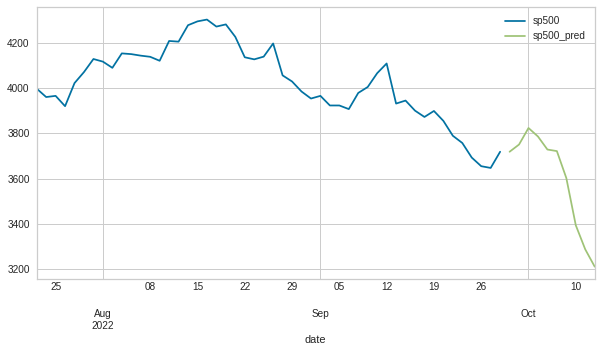

In [402]:
comb_future_df[['sp500','sp500_pred']][-60:].plot(figsize=(10,5))

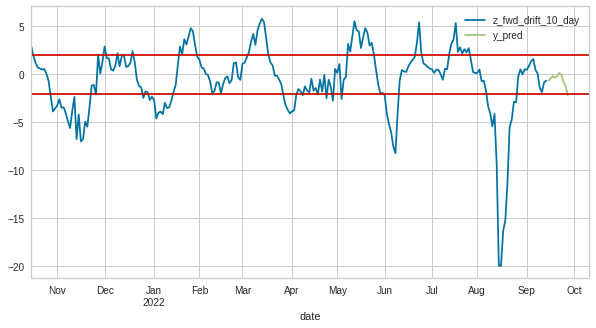

In [409]:
comb_future_df[['z_fwd_drift_10_day','y_pred']][-260:].plot(figsize=(10,5))
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')

<AxesSubplot:xlabel='date'>

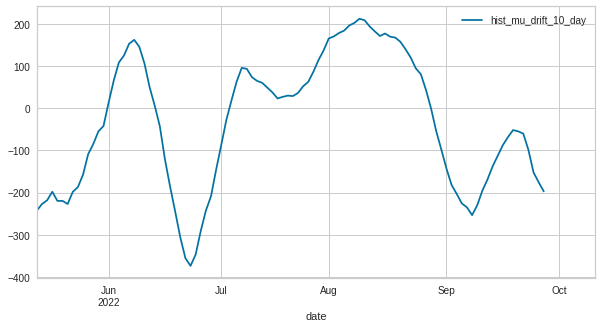

In [404]:
comb_future_df[['hist_mu_drift_10_day']][-110:].plot(figsize=(10,5))

<AxesSubplot:xlabel='date'>

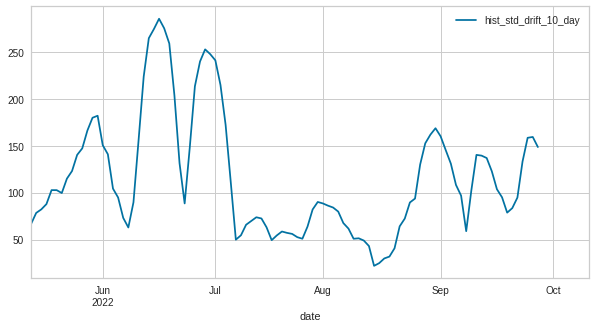

In [405]:
comb_future_df[['hist_std_drift_10_day']][-110:].plot(figsize=(10,5))

In [126]:
exp_exo.save_model(model_exo, "arima_exo_model")

INFO:logs:Initializing save_model()
2022-10-02 09:57:55.066 Initializing save_model()
INFO:logs:save_model(model=ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 0, 5)), model_name=arima_exo_model, prep_pipe_=PyCaretForecastingPipeline(steps=[('numerical_imputer',
                                   Imputer(method='ffill', random_state=42)),
                                  ('forecaster',
                                   TransformedTargetForecaster(steps=[('numerical_imputer',
                                                                       Imputer(method='ffill',
                                                                               random_state=42)),
                                                                      ('model',
                                                                       DummyForecaster())]))]), verbose=True, use_case=MLUsecase.TIME_SERIES, kwargs={})
2022-10-02 09:57:55.075 save_model(model=ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 0, 5)), 

Transformation Pipeline and Model Successfully Saved


(PyCaretForecastingPipeline(steps=[('numerical_imputer',
                                    Imputer(method='ffill', random_state=42)),
                                   ('forecaster',
                                    TransformedTargetForecaster(steps=[('numerical_imputer',
                                                                        Imputer(method='ffill',
                                                                                random_state=42)),
                                                                       ('model',
                                                                        ARIMA(order=(1,
                                                                                     1,
                                                                                     1),
                                                                              seasonal_order=(0,
                                                                                   

**Get future exogenous variable values using forecasting**

In [98]:
exog_vars = ['eqsct', 'hlbeta', 'eqad',
       'credit', 'hlindex']

In [123]:
def get_future_exo_variables(df = pd.DataFrame(), exog_vars=[]):

  exog_exps = []
  exog_models = []
  for exog_var in exog_vars:
      exog_exp = TSForecastingExperiment()
      exog_exp.setup(
          data=df[exog_var], fh=10,seasonal_period=5,
          numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
          fig_kwargs={"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10,
                  "renderer": "png"}, session_id=42
      )

      # Users can customize how to model future exogenous variables i.e. add
      # more steps and models to potentially get better models at the expense
      # of higher modeling time.
      best = exog_exp.compare_models(
          sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
      )
      final_exog_model = exog_exp.finalize_model(best)

      exog_exps.append(exog_exp)
      exog_models.append(final_exog_model)

  # Step 2: Get future predictions for exog variables ----
  future_exog = [
      exog_exp.predict_model(exog_model)
      for exog_exp, exog_model in zip(exog_exps, exog_models)
  ]
  future_exog = pd.concat(future_exog, axis=1)
  future_exog.columns = exog_vars

  return future_exog

In [124]:
future_exog = get_future_exo_variables(df = prep_df, exog_vars = exog_vars)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
ets,ETS,0.0626,0.0793,0.0467,0.0461,0.3384,0.3039,-0.5575,0.5933
exp_smooth,Exponential Smoothing,0.0626,0.0793,0.0467,0.0461,0.3384,0.3039,-0.5583,0.9833
arima,ARIMA,0.0652,0.0736,0.0463,0.0474,0.3525,0.2819,-1.1391,0.6633
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize...,0.1018,0.1226,0.0786,0.0741,0.5508,0.4696,-1.804,0.6667
theta,Theta Forecaster,0.1394,0.1595,0.1044,0.0983,0.7538,0.611,-3.9956,0.1900


INFO:logs:master_model_container: 5
2022-10-02 09:53:35.096 master_model_container: 5
INFO:logs:display_container: 2
2022-10-02 09:53:35.105 display_container: 2
INFO:logs:AutoETS(seasonal='add', sp=5, trend='add')
2022-10-02 09:53:35.110 AutoETS(seasonal='add', sp=5, trend='add')
INFO:logs:compare_models() successfully completed......................................
2022-10-02 09:53:35.113 compare_models() successfully completed......................................
INFO:logs:Initializing finalize_model()
2022-10-02 09:53:35.119 Initializing finalize_model()
INFO:logs:finalize_model(self=<pycaret.time_series.forecasting.oop.TSForecastingExperiment object at 0x7f6cedb530d0>, estimator=AutoETS(seasonal='add', sp=5, trend='add'), fit_kwargs=None, groups=None, model_only=True, experiment_custom_tags=None, display=None)
2022-10-02 09:53:35.122 finalize_model(self=<pycaret.time_series.forecasting.oop.TSForecastingExperiment object at 0x7f6cedb530d0>, estimator=AutoETS(seasonal='add', sp=5, 

In [34]:
ts_data = input_data['sp500']
ts_data = ts_data.asfreq('D')
ts_data.fillna(method='ffill',inplace=True)

In [37]:
exp = TSForecastingExperiment()

In [42]:
exp.setup(data=ts_data, fh=10, session_id=42, fig_kwargs = {"template": "simple_white","hoverinfo":"none"}, train_test_split = 0.7)

TypeError: ignored

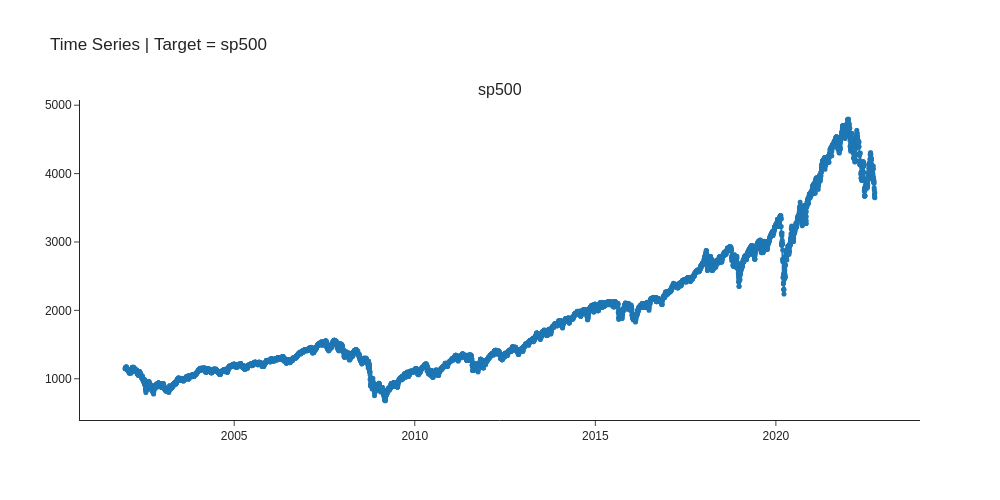

INFO:logs:Visual Rendered Successfully


In [39]:
exp.plot_model(plot="ts",fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

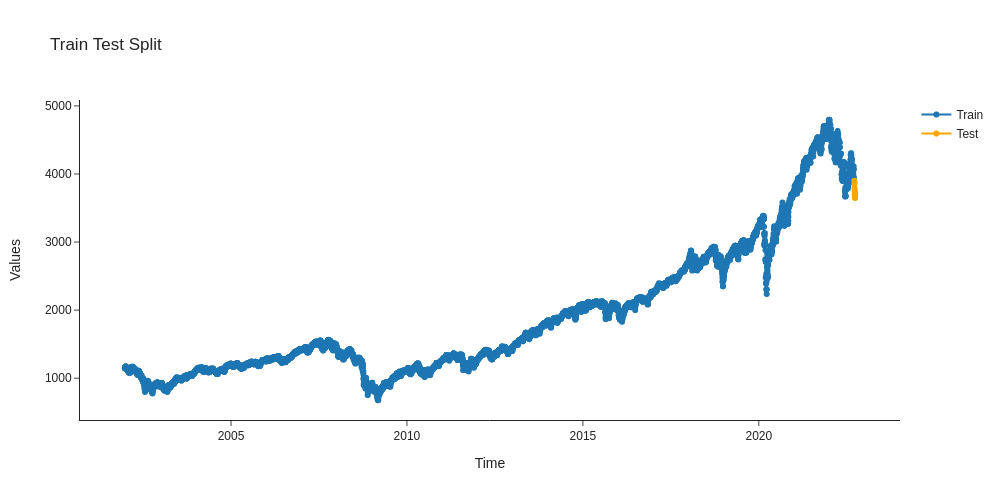

INFO:logs:Visual Rendered Successfully


In [40]:
exp.plot_model(plot="train_test_split",fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

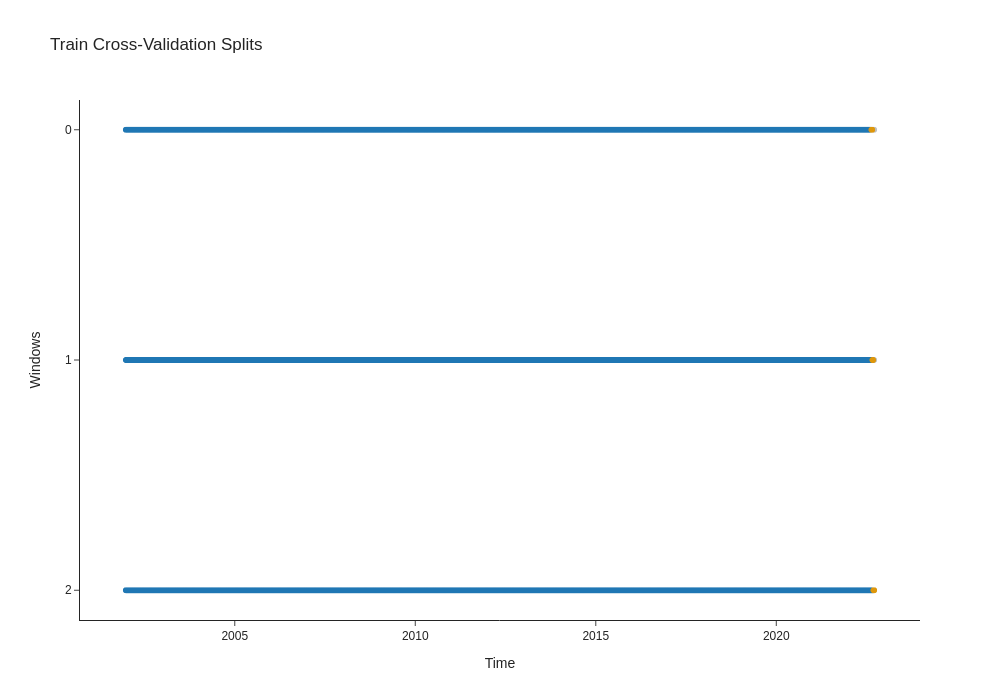

INFO:logs:Visual Rendered Successfully


In [41]:
exp.plot_model(plot="cv",fig_kwargs = {"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [16]:
top4 = exp.compare_models(n_select = 4)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,238.3584,300.4693,0.0707,0.0712,1.2074,1.2665,-0.8784,0.0733
theta,Theta Forecaster,261.2768,320.3116,0.0753,0.0772,1.3215,1.3475,-0.8624,0.0667
exp_smooth,Exponential Smoothing,258.0782,306.8399,0.0784,0.0778,1.3079,1.2949,-1.4311,0.8033
naive,Naive Forecaster,267.1219,324.0536,0.0756,0.0785,1.3502,1.3623,-0.7373,1.2800
ets,ETS,272.0409,324.2684,0.0822,0.0818,1.3781,1.3676,-1.6387,0.1500
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasona...,282.3223,341.8778,0.0813,0.0836,1.4275,1.4379,-1.1481,0.0533
auto_arima,Auto ARIMA,287.8795,338.6386,0.0854,0.0859,1.4562,1.4259,-1.5216,23.1833
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize...,300.8469,357.0442,0.086,0.0886,1.5187,1.4997,-1.2069,0.0567
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detren...,306.9099,366.0511,0.0879,0.0906,1.5493,1.5376,-1.4008,0.0567
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,310.6666,367.9587,0.0896,0.0919,1.5687,1.5463,-1.4929,0.0533


INFO:logs:master_model_container: 29
INFO:logs:display_container: 2
INFO:logs:[BaseCdsDtForecaster(regressor=HuberRegressor(), sp=12, window_length=12), ThetaForecaster(sp=12), ExponentialSmoothing(seasonal='mul', sp=12, trend='add'), NaiveForecaster()]
INFO:logs:compare_models() successfully completed......................................


In [17]:
top4

[BaseCdsDtForecaster(regressor=HuberRegressor(), sp=12, window_length=12),
 ThetaForecaster(sp=12),
 ExponentialSmoothing(seasonal='mul', sp=12, trend='add'),
 NaiveForecaster()]

**Tune Top 4 Models**

In [131]:
for model in range(4):
    exp.tune_model(top4[model])

NameError: ignored

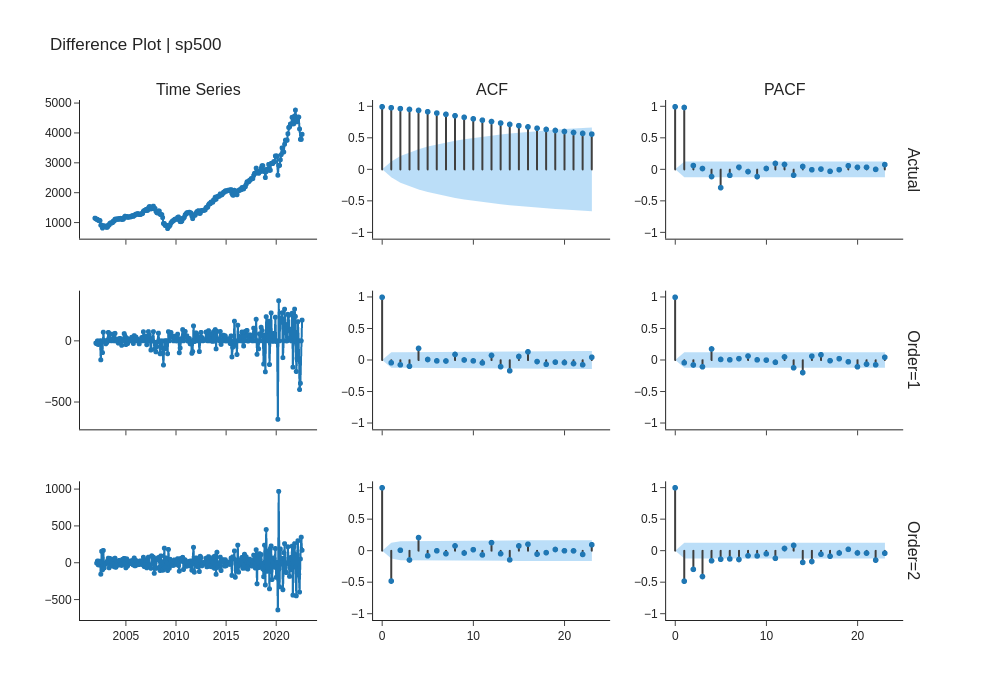

In [18]:
exp.plot_model(plot="diff", 
               data_kwargs={"order_list": [1, 2], "acf": True, "pacf": True},
               fig_kwargs = {"height":700,"width":1000,"template": "simple_white","hoverinfo":"skip","big_data_threshold":10})

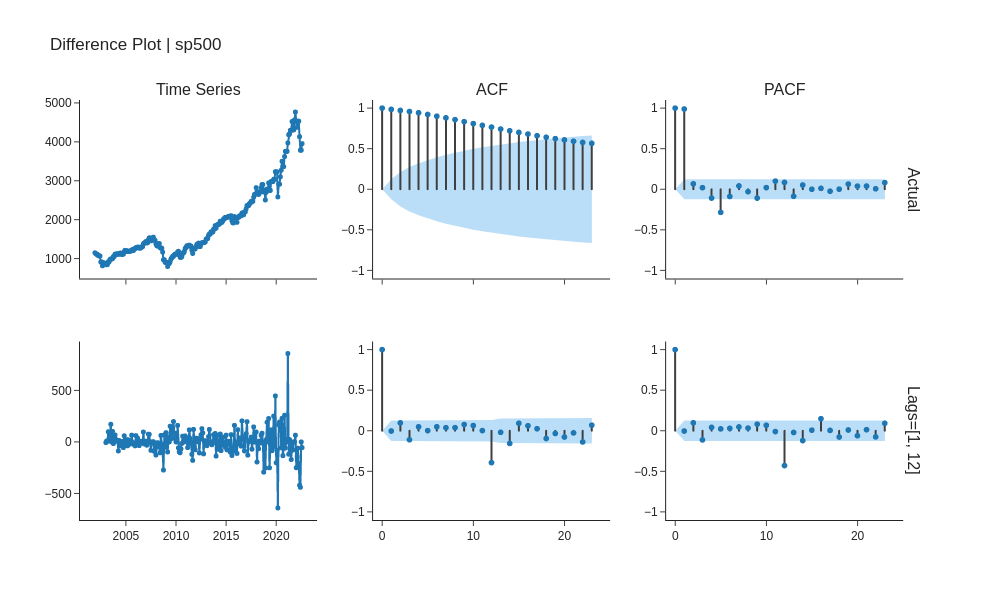

INFO:logs:Visual Rendered Successfully


In [19]:
exp.plot_model(plot="diff", 
               data_kwargs={"lags_list": [[1, 12]], "acf": True, "pacf": True},
               fig_kwargs = {"height":600,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

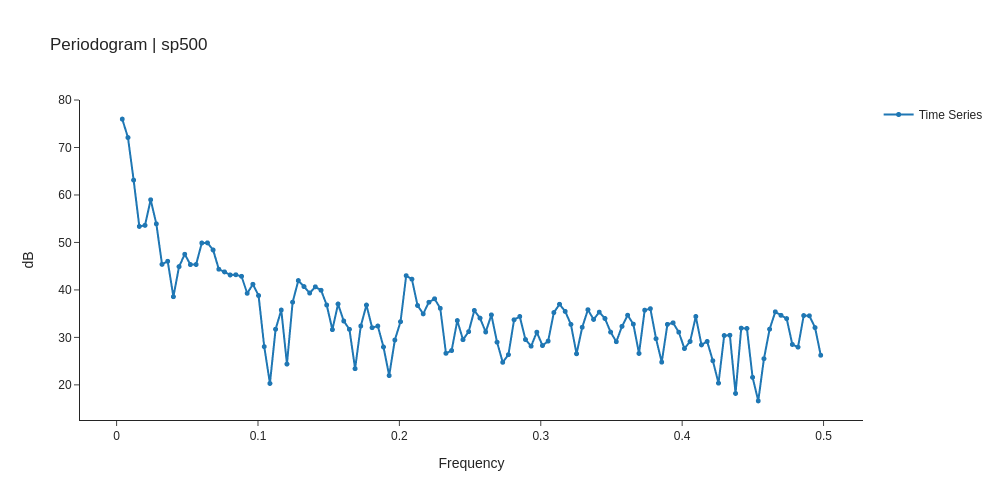

INFO:logs:Visual Rendered Successfully


In [20]:
exp.plot_model(plot = 'periodogram',
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

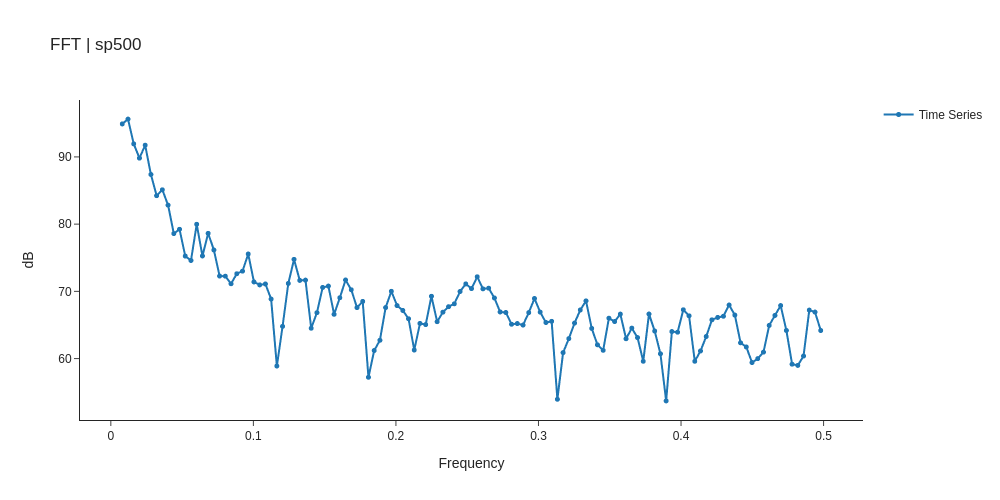

INFO:logs:Visual Rendered Successfully


In [21]:
exp.plot_model(plot = 'fft',fig_kwargs = {"height":500,"width":1000,"hoverinfo":"none","big_data_threshold":10})

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-08,217.2350,257.4959,0.0799,0.0756,1.1077,1.0994,-2.8600
1,2019-08,275.5137,324.2357,0.0877,0.0922,1.4280,1.4018,-1.1228
2,2020-08,564.3549,697.2536,0.1367,0.1522,2.8154,2.8810,-2.6694
Mean,NaT,352.3679,426.3284,0.1014,0.1067,1.7837,1.7941,-2.2174
SD,NaT,151.7739,193.5009,0.0251,0.0329,0.7411,0.7784,0.7779


INFO:logs:master_model_container: 30
INFO:logs:display_container: 3
INFO:logs:ARIMA(seasonal_order=(0, 1, 0, 12))
INFO:logs:create_model() successfully completed......................................


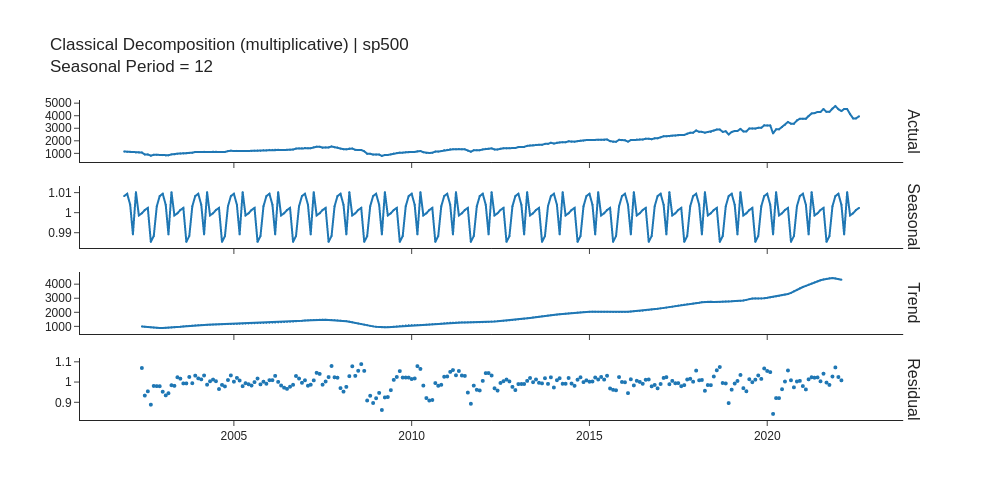

INFO:logs:Visual Rendered Successfully


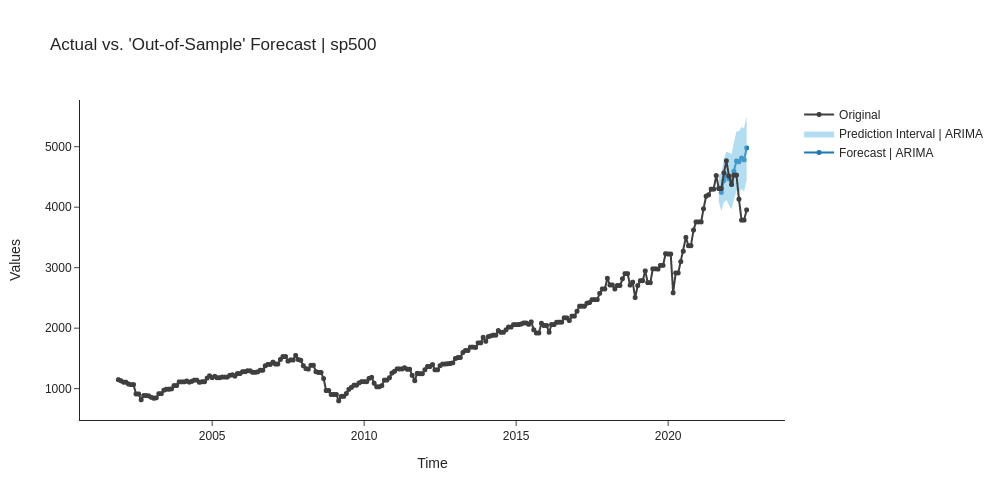

INFO:logs:Visual Rendered Successfully


In [22]:
arima = exp.create_model('arima')
exp.plot_model(plot = 'decomp',
               data_kwargs = {'type' : 'multiplicative'},
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})
exp.plot_model(estimator = arima, plot = 'forecast', 
               data_kwargs = {'fh' : 12},
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [23]:
exp.check_stats(arima, test = 'all')

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Residual,Length,,237.0
1,Summary,Statistics,Residual,Mean,,35.010749
2,Summary,Statistics,Residual,Median,,0.9385
3,Summary,Statistics,Residual,Standard Deviation,,192.432744
4,Summary,Statistics,Residual,Variance,,37030.361063
5,Summary,Statistics,Residual,Kurtosis,,9.400236
6,Summary,Statistics,Residual,Skewness,,2.110698
7,Summary,Statistics,Residual,# Distinct Values,,236.0
8,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 24}",234.186977
9,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 48}",238.55839


,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-08,166.2457,204.0540,0.0616,0.0588,0.8477,0.8712,-1.4240
1,2019-08,184.0872,229.8682,0.0598,0.0602,0.9542,0.9938,-0.0669
2,2020-08,433.4975,527.0127,0.1045,0.1127,2.1626,2.1776,-1.0963
Mean,NaT,261.2768,320.3116,0.0753,0.0772,1.3215,1.3475,-0.8624
SD,NaT,121.9961,146.5392,0.0207,0.0251,0.5963,0.5891,0.5782


INFO:logs:master_model_container: 31
INFO:logs:display_container: 6
INFO:logs:ThetaForecaster(sp=12)
INFO:logs:create_model() successfully completed......................................


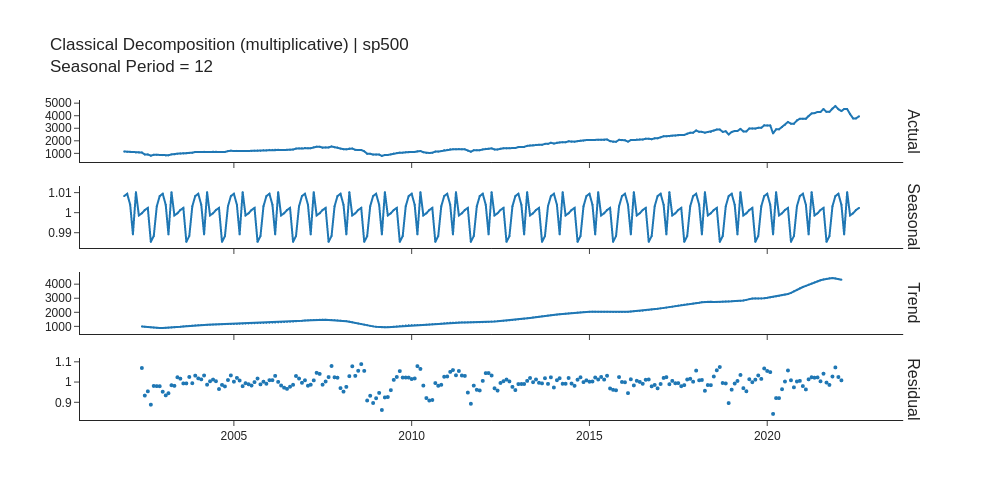

INFO:logs:Visual Rendered Successfully


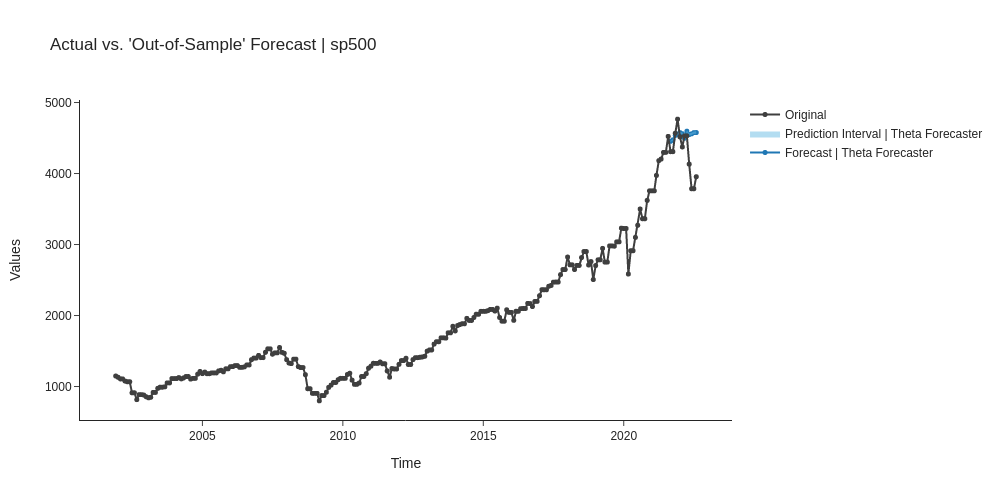

INFO:logs:Visual Rendered Successfully


In [24]:
theta = exp.create_model('theta')
exp.plot_model(plot = 'decomp', 
               data_kwargs = {'type' : 'multiplicative'},
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})
exp.plot_model(estimator = theta, plot = 'forecast', 
               data_kwargs = {'fh' : 12},
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [25]:
exp.check_stats(theta, test = 'all')

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Residual,Length,,237.0
1,Summary,Statistics,Residual,Mean,,627.99801
2,Summary,Statistics,Residual,Median,,609.5541
3,Summary,Statistics,Residual,Standard Deviation,,351.812646
4,Summary,Statistics,Residual,Variance,,123772.137975
5,Summary,Statistics,Residual,Kurtosis,,-0.782593
6,Summary,Statistics,Residual,Skewness,,-0.097345
7,Summary,Statistics,Residual,# Distinct Values,,237.0
8,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 24}",4025.740279
9,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 48}",5914.448556


,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-08,277.8002,305.6194,0.1013,0.0953,1.4166,1.3049,-4.4376
1,2019-08,164.9900,215.8850,0.0550,0.0540,0.8552,0.9333,0.0589
2,2020-08,373.3325,451.3009,0.0903,0.0962,1.8624,1.8647,-0.5373
Mean,NaT,272.0409,324.2684,0.0822,0.0818,1.3781,1.3676,-1.6387
SD,NaT,85.1529,97.0086,0.0197,0.0197,0.4121,0.3828,1.9941


INFO:logs:master_model_container: 32
INFO:logs:display_container: 9
INFO:logs:AutoETS(seasonal='mul', sp=12, trend='add')
INFO:logs:create_model() successfully completed......................................


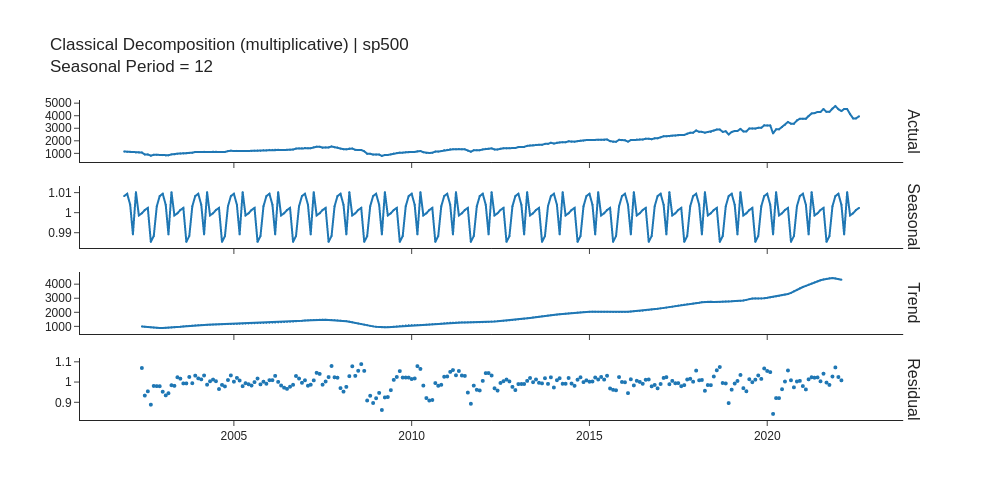

INFO:logs:Visual Rendered Successfully


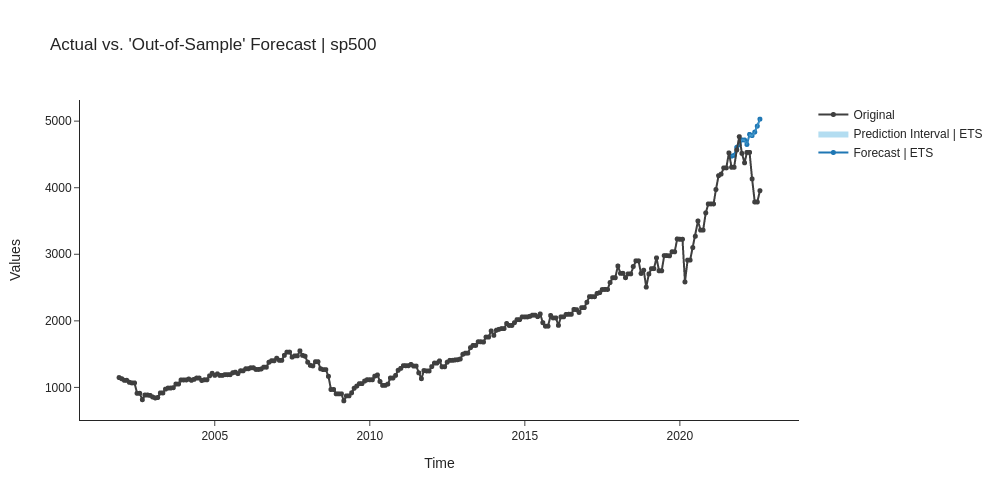

INFO:logs:Visual Rendered Successfully


In [26]:
ets_dt = exp.create_model('ets')
exp.plot_model(plot = 'decomp', 
               data_kwargs = {'type' : 'multiplicative'},
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})
exp.plot_model(estimator = ets_dt, 
               plot = 'forecast', 
               data_kwargs = {'fh' : 12},
               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [27]:
exp.check_stats(ets_dt, test = 'all')

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Residual,Length,,237.0
1,Summary,Statistics,Residual,Mean,,8.351903
2,Summary,Statistics,Residual,Median,,9.8804
3,Summary,Statistics,Residual,Standard Deviation,,80.343568
4,Summary,Statistics,Residual,Variance,,6455.088895
5,Summary,Statistics,Residual,Kurtosis,,13.475166
6,Summary,Statistics,Residual,Skewness,,-1.647798
7,Summary,Statistics,Residual,# Distinct Values,,237.0
8,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 24}",41.219867
9,White Noise,Ljung-Box,Residual,Test Statictic,"{'alpha': 0.05, 'K': 48}",55.322098


In [28]:
for model in range(4):
    exp.tune_model(top4[model])

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-08,161.5010,200.9763,0.0599,0.0571,0.8235,0.8581,-1.3515
1,2019-08,173.2457,221.4176,0.0567,0.0566,0.8980,0.9572,0.0101
2,2020-08,406.7613,484.1761,0.0987,0.1053,2.0292,2.0006,-0.7694
Mean,NaT,247.1693,302.1900,0.0717,0.0730,1.2502,1.2720,-0.7036
SD,NaT,112.9504,128.9539,0.0191,0.0229,0.5517,0.5168,0.5578


INFO:logs:master_model_container: 43
INFO:logs:display_container: 15
INFO:logs:NaiveForecaster(strategy='drift')
INFO:logs:tune_model() succesfully completed......................................


In [29]:
blender = exp.blend_models(top4)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-08,182.2367,219.0068,0.0673,0.0641,0.9293,0.9351,-1.7923
1,2019-08,173.4810,222.0989,0.0568,0.0567,0.8992,0.9602,0.0040
2,2020-08,398.5398,484.3986,0.0962,0.1030,1.9882,2.0015,-0.7710
Mean,NaT,251.4192,308.5014,0.0734,0.0746,1.2722,1.2989,-0.8531
SD,NaT,104.0914,124.3845,0.0166,0.0203,0.5064,0.4969,0.7356


INFO:logs:master_model_container: 44
INFO:logs:display_container: 16
INFO:logs:_EnsembleForecasterWithVoting(forecasters=[('HuberRegressor',
                                            BaseCdsDtForecaster(regressor=HuberRegressor(),
                                                                sp=12,
                                                                window_length=12)),
                                           ('Theta Forecaster',
                                            ThetaForecaster(sp=12)),
                                           ('Exponential Smoothing',
                                            ExponentialSmoothing(seasonal='mul',
                                                                 sp=12,
                                                                 trend='add')),
                                           ('Naive Forecaster',
                                            NaiveForecaster())],
                              n_jobs=-1)
INFO:lo

In [30]:
final_model = exp.finalize_model(blender)
pred_holdout = exp.predict_model(final_model)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(self=<pycaret.time_series.forecasting.oop.TSForecastingExperiment object at 0x7fbd2c529e10>, estimator=_EnsembleForecasterWithVoting(forecasters=[('HuberRegressor',
                                            BaseCdsDtForecaster(regressor=HuberRegressor(),
                                                                sp=12,
                                                                window_length=12)),
                                           ('Theta Forecaster',
                                            ThetaForecaster(sp=12)),
                                           ('Exponential Smoothing',
                                            ExponentialSmoothing(seasonal='mul',
                                                                 sp=12,
                                                                 trend='add')),
                                           ('Naive Forecaster',
                        

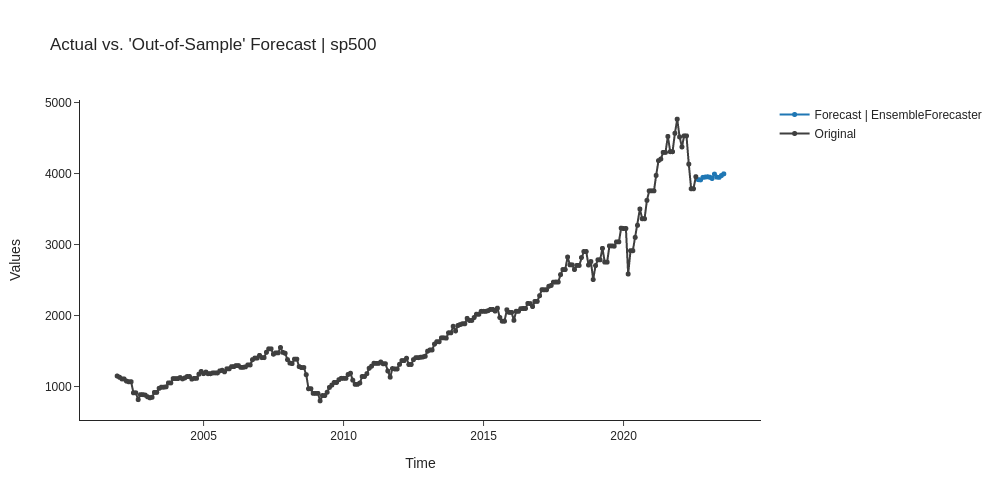

INFO:logs:Visual Rendered Successfully


In [31]:
exp.plot_model(final_model,fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

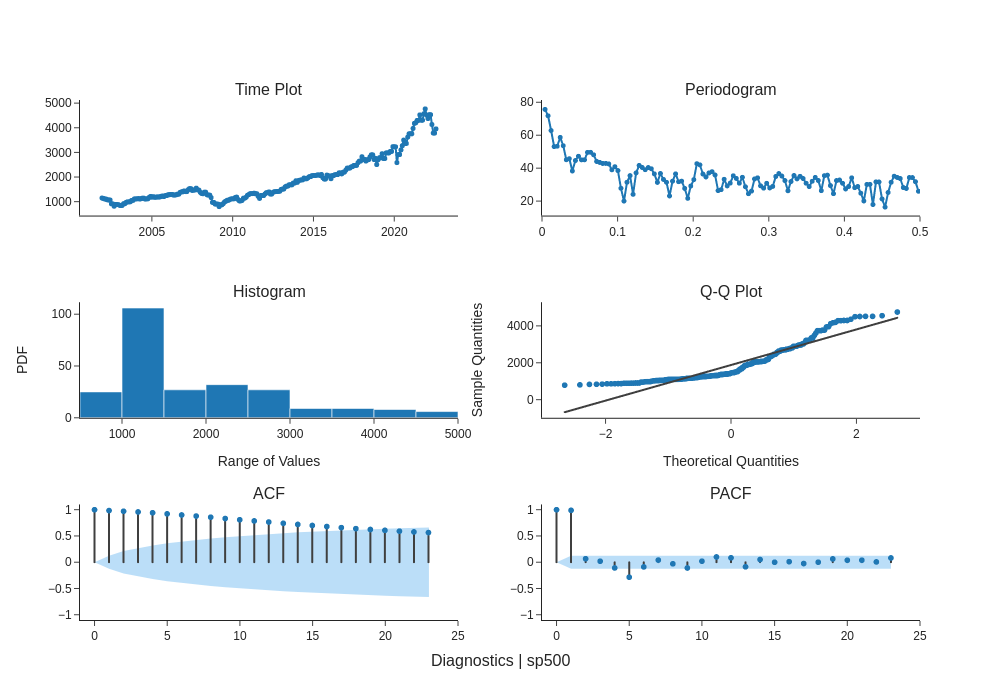

INFO:logs:Visual Rendered Successfully


In [32]:
exp.plot_model(plot = 'diagnostics',fig_kwargs = {"height":700,"width":1000,"600": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [33]:
pred_holdout

,y_pred
2022-09,3913.6688
2022-10,3909.8851
2022-11,3945.8002
2022-12,3950.2695
2023-01,3954.1210
2023-02,3947.0751
2023-03,3929.8658
2023-04,3991.9056
2023-05,3949.0269
2023-06,3945.8459
